# Problem

Baramati is a deeply agrarian region with a wide variety of farming practices. Climate, technology and disease risk when taken into account can a give us a rough idea of how these factors play into the type of agricultural practices taken up by Baramati's farmers.

In this model, we are going to explore which of these practices tends to benefit crops and which of these practices lead to failure of crops.

# Data


## 1) Location

According to source:https://www.researchgate.net/publication/314377473_Agricultural_Productivity_of_the_Baramati_Tahsil_Pune_District_Maharashtra

6 villages are representative of Baramati: Supe, Undavadi Supe, Loni, Bhapkar, Vadgaon  Nimbalkar, Malegaon Bk and Baramati Rural. These are the locations that we are considering for simulating the data.

## 2) Crop Type

Sugarcane, Cotton, Wheat and Grapes are generally grown in Baramati

## 3) Climate

The climate has been generalised to 4 factors. The plantation temperature, average rainfall, required plantation temperature and required rainfall. 

Baramati is notorious for having dry spells ruin crops thus this data will be extremely helpful in figuring out the critical values of these variables at which crops fail.

## 4) Plantation Month

The initial climate values will correspond to the month in which the crops are planted as initial conditions are very sensitive to planting crops.

## 5) Method of Irrigation

Whether the crops are river fed, rain fed or artifically irrigated.
Encoding : 0 - rain fed
           1 - river fed
           2 - artifically irrigated

## 6) Drought Risk associated with the region:

Described as a percentage

## 7) Method of Agriculture:

Whether crops are handled by labourers by hand or whether machines are used extensively 
Encoding : 0 - by hand
           1 - by machines

## 8) Soil Type: 

Whether sodic or non sodic soil has been used. ( Sodic high is sodium and tends to be more saline)
Encoding : 0 - non-sodic
           1 - sodic

## 9) Soil Salinity:

Typically increases with excessive use of pesticides. Given here in units of grams per litre.

## 9) Fertilizer use per acre:

More Saline soils i.e sodic soils need more fertilizer. Given here in kilograms used per acre.

## 10) Pesticide use per acre:

Average use per acre = 141.4, but crops like cotton take up more and crops like wheat take up less.
Given here as a function of grams/acre.

## 11) Wealth:

Wealthy farmers are more likely to have better equipment.
Encoding : 0 - less capital (poor)
           1 - more capital (rich)

## 11) Agricultural Practices Used (Treatment):

Whether crop rotation was used or not. (A sustainable practice)
Encoding : 0 - No
           1 - Yes

## 12) Crop Success (Outcome): 

Whether the crop succeeded or not
Encoding : 0 - No
           1 - Yes




# Creating the Data

In [1]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

# Generic ML imports
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures

# DoWhy imports 
import dowhy
from dowhy import CausalModel
from dowhy import gcm

import sklearn

from sklearn.preprocessing import LabelEncoder


import matplotlib.pyplot as plt
%matplotlib inline

import random

## Constant Given Data

This is data that has already been collected. 
For eg. We know the average temperature in Baramati for all 12 months. 
source : https://en.climate-data.org/asia/india/maharashtra/baramati-767162/#climate-table

We also know the required average temperature and rainfall for all 4 crop as well as the specific areas in which they were planted.

In [2]:
#setting of  constant data

crops = ['sugarcane','wheat','grapes','cotton']
reqrain = [130,75,75,50]
reqtemp = [30,25,29,25] # required temperature for all 4 crops 
normaltemp = [23,26,29,32,32,27,25,25,25,26,23,22] # average temperature in Baramati for all 12 months
places = ['Supe', 'Undavadi Supe', 'Loni Bhapkar', 'Vadgaon Nimbalkar', 'Malegaon Bk','Baramati Rural'] #all locations

We now randomise the crops planted in each location and set the required 

In [3]:
cropcol = pd.Series('cotton')

reqtempc = pd.Series(25) 
reqraincol = pd.Series(50)


raincol = pd.Series(60)
placescol = pd.Series('Supe')
i=1

while i<1000:
    #random integers for all columns 
    cropint=random.randint(0,3)
    rainint = random.randint(-15,15)
    placeint = random.randint(0,5)
    
    placescol.at[placescol.index[-1]+1] = places[placeint] #setting randomised places
    cropcol.at[cropcol.index[-1]+1]=crops[cropint] #setting randomised crops
    
    raincol.at[raincol.index[-1]+1]=reqrain[cropint]-rainint #setting the average rain along with some noise
    
   
    reqraincol.at[reqraincol.index[-1]+1]=reqrain[cropint] #setting the required rain
    reqtempc.at[reqtempc.index[-1]+1]= reqtemp[cropint] #setting the required temperature
    
    
    i+=1
   

In [4]:
#creating a dictionary to store all our data
dict1 = {'Location':placescol,'CropType':cropcol,'AverageAnnualRain(cm)':raincol,'RequiredAnnualRain(cm)':reqraincol}

In [5]:
agri = pd.DataFrame(dict1) # creating it into a dataframe
print(agri)

              Location   CropType  AverageAnnualRain(cm)  \
0                 Supe     cotton                     60   
1          Malegaon Bk      wheat                     82   
2          Malegaon Bk     cotton                     57   
3          Malegaon Bk  sugarcane                    141   
4         Loni Bhapkar      wheat                     76   
..                 ...        ...                    ...   
995     Baramati Rural     grapes                     75   
996     Baramati Rural      wheat                     78   
997               Supe     cotton                     51   
998  Vadgaon Nimbalkar  sugarcane                    134   
999        Malegaon Bk     grapes                     83   

     RequiredAnnualRain(cm)  
0                        50  
1                        75  
2                        50  
3                       130  
4                        75  
..                      ...  
995                      75  
996                      75  
997      

For irrigation, approximately 20% of baramatis farmers have artifical irrigation and about 30% rely on river fed agriculture

In [6]:
#setting of irrigation method
i=1
irr=pd.Series(0)
while i<1000:
    method = random.randint(0,9)
    
    if(method<5):
        irr.at[irr.index[-1]+1]=0 # rain fed = 0
    elif(method>7):
         irr.at[irr.index[-1]+1]=2 # artificially irrigated = 2
    else:
         irr.at[irr.index[-1]+1]=1 # river fed = 1
    
    
    
    i+=1
agri['Irrigation'] = irr

Depending on the type of crop that is planted and whether it is rain fed or river fed or not, the plantation month changes.

Cotton rain fed planted may-july
       irrigated planted march-may
Sugarcane rain fed planted oct-dec
          irrigated planted jan-march
... and so on for all the plants 

In [7]:
#setting plantation month

i=1 

month = pd.Series(6) 

while(i<1000):
    
    noise = random.randint(-1,1)
    if(cropcol[i]=='cotton'):
        if(irr[i]==0):
            month.at[month.index[-1]+1]=6+noise 
        else:
            month.at[month.index[-1]+1]=4+noise
    elif(cropcol[i]=='sugarcane'):
        if(irr[i]==2):
            month.at[month.index[-1]+1]=11+noise
        else:
            month.at[month.index[-1]+1]=2+noise 
    elif(cropcol[i]=='grapes'):
        month.at[month.index[-1]+1]=2+noise
    else:
        month.at[month.index[-1]+1]=11+noise
    i+=1        
            
agri['PlantationMonth'] = month        #setting the plantation months    

    

Initial temperature while planting the crops is dependent on the temperature at baramati at the time. Required temperature is constant from given data.

In [8]:
    #setting initial temperature and required temperature

    i=1

    tem = pd.Series(27)


    while(i<1000):
        noise - random.randint(-1,2)
    
        tem.at[tem.index[-1]+1]=normaltemp[month[i]-1]+noise
        i+=1
    
    agri['InitialTemp(C)'] = tem
    agri['RequiredTemp(C)'] = reqtempc

Baramati has an even distribution of sodic and non-sodic soils thus we can randomize them 50-50.

In [9]:


sod=pd.Series('Sodic')
i=1
while(i<1000):
    
    
    
    sodint = random.randint(0,1)
    
    
    if(sodint==0):
        sod.at[sod.index[-1]+1]='Non-Sodic'
    else:
        sod.at[sod.index[-1]+1]='Sodic'
   
    i+=1     
agri['SoilType'] = sod #setting the soil type

In [10]:
print(agri) # look at the updated dataframe

              Location   CropType  AverageAnnualRain(cm)  \
0                 Supe     cotton                     60   
1          Malegaon Bk      wheat                     82   
2          Malegaon Bk     cotton                     57   
3          Malegaon Bk  sugarcane                    141   
4         Loni Bhapkar      wheat                     76   
..                 ...        ...                    ...   
995     Baramati Rural     grapes                     75   
996     Baramati Rural      wheat                     78   
997               Supe     cotton                     51   
998  Vadgaon Nimbalkar  sugarcane                    134   
999        Malegaon Bk     grapes                     83   

     RequiredAnnualRain(cm)  Irrigation  PlantationMonth  InitialTemp(C)  \
0                        50           0                6              27   
1                        75           1               11              24   
2                        50           0            

In [11]:
pesticide = pd.Series(200)
fertilizer = pd.Series(150)
salinity = pd.Series(10)

Average pesticide used in India per hectare is 350 grams. When taken per acre that reduces to 144.

Cotton requires upto 96% more pesticide than average and wheat requires upto 96% less.

Thus we add some noise and condition over the crops to  generate pesticide per acre.

In [12]:
#setting pesticide

i=1

while(i<1000):
    noise = random.randint(-10,10)
    if(cropcol[i]=='cotton'):
        pesticide.at[pesticide.index[-1]+1]=190+noise
    elif(cropcol[i]=='wheat'):
        pesticide.at[pesticide.index[-1]+1]=100+noise
    else:
        pesticide.at[pesticide.index[-1]+1]=144+noise
    
    i+=1


In [13]:
agri['Pesticide(gm/Acre)'] = pesticide

print(agri)

              Location   CropType  AverageAnnualRain(cm)  \
0                 Supe     cotton                     60   
1          Malegaon Bk      wheat                     82   
2          Malegaon Bk     cotton                     57   
3          Malegaon Bk  sugarcane                    141   
4         Loni Bhapkar      wheat                     76   
..                 ...        ...                    ...   
995     Baramati Rural     grapes                     75   
996     Baramati Rural      wheat                     78   
997               Supe     cotton                     51   
998  Vadgaon Nimbalkar  sugarcane                    134   
999        Malegaon Bk     grapes                     83   

     RequiredAnnualRain(cm)  Irrigation  PlantationMonth  InitialTemp(C)  \
0                        50           0                6              27   
1                        75           1               11              24   
2                        50           0            

Excessive use of pesticides tends to result in highly saline soils that don't allow for permeation of nutritients.
Sodic soils also tend to be saline. Thus, we add some noise and get an idea about the salinity.

In [14]:
#setting soil salinity 

i=1 

while(i<1000):
    sal=0
    noise1 = random.randint(1,3)
    if(agri['SoilType'][i]=='Sodic'):
        sal=8
    else:
        sal=4
    if(agri['Pesticide(gm/Acre)'][i]>agri['Pesticide(gm/Acre)'].mean()):
        sal+=noise1
    
    salinity.at[salinity.index[-1]+1]=sal
    
    
    i+=1
agri['Salinity(g/l)'] = salinity
print(agri)

              Location   CropType  AverageAnnualRain(cm)  \
0                 Supe     cotton                     60   
1          Malegaon Bk      wheat                     82   
2          Malegaon Bk     cotton                     57   
3          Malegaon Bk  sugarcane                    141   
4         Loni Bhapkar      wheat                     76   
..                 ...        ...                    ...   
995     Baramati Rural     grapes                     75   
996     Baramati Rural      wheat                     78   
997               Supe     cotton                     51   
998  Vadgaon Nimbalkar  sugarcane                    134   
999        Malegaon Bk     grapes                     83   

     RequiredAnnualRain(cm)  Irrigation  PlantationMonth  InitialTemp(C)  \
0                        50           0                6              27   
1                        75           1               11              24   
2                        50           0            

Average fertilizer used per acre in India is 150 kgs. Highly saline areas need to be fertilized more due to lack of nutrients.
Thus conditioning over salinity we can get an idea about fertilizer used per acre.

In [15]:
#setting fertilizers

i=1

while(i<1000):
    noise4 = random.randint(0,30)
    if(agri['Salinity(g/l)'][i]>agri['Salinity(g/l)'].mean()):
        fertilizer.at[fertilizer.index[-1]+1]=150+noise4
    else:
        fertilizer.at[fertilizer.index[-1]+1]=150-noise4
    i+=1
agri['Fertilizer(kg/acre)'] = fertilizer

print(agri)

              Location   CropType  AverageAnnualRain(cm)  \
0                 Supe     cotton                     60   
1          Malegaon Bk      wheat                     82   
2          Malegaon Bk     cotton                     57   
3          Malegaon Bk  sugarcane                    141   
4         Loni Bhapkar      wheat                     76   
..                 ...        ...                    ...   
995     Baramati Rural     grapes                     75   
996     Baramati Rural      wheat                     78   
997               Supe     cotton                     51   
998  Vadgaon Nimbalkar  sugarcane                    134   
999        Malegaon Bk     grapes                     83   

     RequiredAnnualRain(cm)  Irrigation  PlantationMonth  InitialTemp(C)  \
0                        50           0                6              27   
1                        75           1               11              24   
2                        50           0            

In [16]:
drought = pd.Series(0.5)

Baramati is famous for its drought problem. We calculate this drought risk by finding out whether the average rain is sufficient enough to satisfy the required rain amount. 
If not, then the drought risk percentage is calculated as a fucntion of the difference between the required rain and average rain.

In [17]:
i =1

while(i<1000):
    noise =random.randint(0,2)
    
    if(agri['AverageAnnualRain(cm)'][i]>=agri['RequiredAnnualRain(cm)'][i]):
        drought.at[drought.index[-1]+1]=noise*0.1*100
    else:
        drought.at[drought.index[-1]+1]= (1-(agri['AverageAnnualRain(cm)'][i]/agri['RequiredAnnualRain(cm)'][i]))*300
    i+=1
agri['DroughtRisk(%)']=drought

print(agri)

              Location   CropType  AverageAnnualRain(cm)  \
0                 Supe     cotton                     60   
1          Malegaon Bk      wheat                     82   
2          Malegaon Bk     cotton                     57   
3          Malegaon Bk  sugarcane                    141   
4         Loni Bhapkar      wheat                     76   
..                 ...        ...                    ...   
995     Baramati Rural     grapes                     75   
996     Baramati Rural      wheat                     78   
997               Supe     cotton                     51   
998  Vadgaon Nimbalkar  sugarcane                    134   
999        Malegaon Bk     grapes                     83   

     RequiredAnnualRain(cm)  Irrigation  PlantationMonth  InitialTemp(C)  \
0                        50           0                6              27   
1                        75           1               11              24   
2                        50           0            

Having capital and technology also play a large part in the success of crops. Around 30% of Baramati's farmers can be considered to have sufficient capital.

These rich farmers also tend to have a much higher chance of owning High Tech devices to help with agriculture.
eg. Tractors, Seed Drills

In [18]:
# setting the technology variable and the wealth variable

labour = pd.Series(0)
wealth = pd.Series(0)
i=1

while(i<1000):
    noise5=random.randint(0,9)
    noise6=random.randint(0,9)
    
    if(noise5<3):
        wealth.at[wealth.index[-1]+1]=1
    else:
        wealth.at[wealth.index[-1]+1]=0
    if(wealth[i]==1):
        if(noise6>3):
            labour.at[labour.index[-1]+1]=1
        else:
            labour.at[labour.index[-1]+1]=0
    else:
        if(noise6>6):
             labour.at[labour.index[-1]+1]=1
        else:
             labour.at[labour.index[-1]+1]=0
    i+=1         
    
#code summarised: around 70% of farmers are relatively poor and out of these farmers only about 30% own high tech devices (like 
#tractors and seedrills and out of the rich farmers: around 70% own high tech devices)
agri['HighTechnology'] = labour

agri['RelativeWealth'] = wealth

from sklearn.preprocessing import LabelEncoder

soil_enc = LabelEncoder()

agri['SoilType']=soil_enc.fit_transform(agri['SoilType'])

In [19]:
print(agri)

              Location   CropType  AverageAnnualRain(cm)  \
0                 Supe     cotton                     60   
1          Malegaon Bk      wheat                     82   
2          Malegaon Bk     cotton                     57   
3          Malegaon Bk  sugarcane                    141   
4         Loni Bhapkar      wheat                     76   
..                 ...        ...                    ...   
995     Baramati Rural     grapes                     75   
996     Baramati Rural      wheat                     78   
997               Supe     cotton                     51   
998  Vadgaon Nimbalkar  sugarcane                    134   
999        Malegaon Bk     grapes                     83   

     RequiredAnnualRain(cm)  Irrigation  PlantationMonth  InitialTemp(C)  \
0                        50           0                6              27   
1                        75           1               11              24   
2                        50           0            

We are using treatment as a function of many different factors

Assuming treatment T(i) = treatment of the ith farmer, we have

T(i) = DroughtRisk(i)*1/20 - Irrigation(i)*2 + SoilType(i)*2 + Salinity(i)*1/4 - Fertilizer(i)*1/150 - Pesticide(i)/144
        - Wealth(i)*1
Treatment here indicates whether the farmer is using crop rotation or not

People with artifical irrigation don't need to pratice crop rotation. Sodic soils benefit the most from the nutrients that are given out by crop rotation thus it affects it positively. Saline soil tends to benefit the most from crop rotation. Fertilized soil doesn't need crop rotation most of the times. Drought farms have the most benefit from treatment as they are the ones most affected by absense of nutrition. Farmers who use a lot of pesticide also tend to not benefit from treatment as crop rotation is most benefical when done organically. Wealthy farmers are also dissuaded from treatment in general due to the lack of dire need of sustainable crops.

In [20]:
treat = pd.Series(0)

i =1

while(i<1000):
    treat.at[treat.index[-1]+1]=irr[i]*-2  + salinity[i]/4 - fertilizer[i]/150 - wealth[i]*2 + drought[i]*1/20 + agri['SoilType'][i]*2
    - pesticide[i]/144
    i+=1
agri['AgriculturalPractice'] = treat

i = 1

while(i<1000):
    if(agri['AgriculturalPractice'].mean()>agri['AgriculturalPractice'][i]):
        agri['AgriculturalPractice'][i]=0
    else:
        agri['AgriculturalPractice'][i]=1
    i+=1

   
    
  
    
    
    

Crop outcome here is taken as a fucntion of the absolute difference between the initial temperature and required temperature, pesticide use, soil salinity, fertilizer use, drought risk and technology used.

Crop failure is very sensitive to initial conditions therefore the difference in temperatures is used.

Excessive pesticide is rampant in some farms which leads to crop failure.

Excessively saline soil blocks out nutrients from the soil due to lesser osmosis taking place.

Excessive fertilizer also can be toxic for many plants contributing negatively to crop success.

High drought risk will lead to crop failure and better technology results in more effecient farms which have less crop failure.

In [21]:
#setting crop outcomes

success = pd.Series(0)

i=1

while(i<1000):
    var=0
    if(abs(agri['InitialTemp(C)'][i]-agri['RequiredTemp(C)'][i])>4):
        var-= abs(agri['InitialTemp(C)'][i]-agri['RequiredTemp(C)'][i])*0.1
    if(agri['Pesticide(gm/Acre)'][i]>agri['Pesticide(gm/Acre)'][i]):
        var-=0.3
    else:
        var+=0.2
    if(salinity[i]>7):
        var-=0.1
    else:
        var+=0.2
    if(fertilizer[i]>175 or fertilizer[i]<115):
        var-=0.2
    if(drought[i]>40):
        var-=0.2
    if(labour[i]==1):
        var+=0.1
    
    #code summary: each factor has been given certain importance and the varaible var has been scaled accordingly
        
    
    success.at[success.index[-1]+1]=var
    i+=1
    
agri['CropSuccess']=success
i = 1

while(i<1000):
        if(agri['CropSuccess'][i]>=agri['CropSuccess'].mean()):
            agri['CropSuccess'][i]=1
        else:
            agri['CropSuccess'][i]=0
        if(agri['AgriculturalPractice'][i]==1):
            noise7 = random.randint(0,4)
            if(noise7!=0):
                if(agri['CropSuccess'][i]==0):
                    agri['CropSuccess'][i]=1
        
        i+=1

    #code summary: all var above the mean have been considered to be a successful crop whereas all below the man are unsuccessful
    # and since this is simulated data we have intervened on all would have been failed crops for T=1 by giving thema  80% chance
    #of succeeding

## Final Data

In [22]:
print(agri)

              Location   CropType  AverageAnnualRain(cm)  \
0                 Supe     cotton                     60   
1          Malegaon Bk      wheat                     82   
2          Malegaon Bk     cotton                     57   
3          Malegaon Bk  sugarcane                    141   
4         Loni Bhapkar      wheat                     76   
..                 ...        ...                    ...   
995     Baramati Rural     grapes                     75   
996     Baramati Rural      wheat                     78   
997               Supe     cotton                     51   
998  Vadgaon Nimbalkar  sugarcane                    134   
999        Malegaon Bk     grapes                     83   

     RequiredAnnualRain(cm)  Irrigation  PlantationMonth  InitialTemp(C)  \
0                        50           0                6              27   
1                        75           1               11              24   
2                        50           0            

# Using DoWhy For Treatment Effects

The DoWhy library is primarily based on finding out if there exists a causal effect between two variables: the treatment variable and the the outcome variable.

In this Jupyter notebook, we can estimate the effect that certain Agricultural Practices have on crop success.

# Creating the Causal Model

Based on the relationships through which we simulated the data, we already know the causal associations between the variables.

We can create a causal DAG in graphviz here and then use that graph for further creating the model.

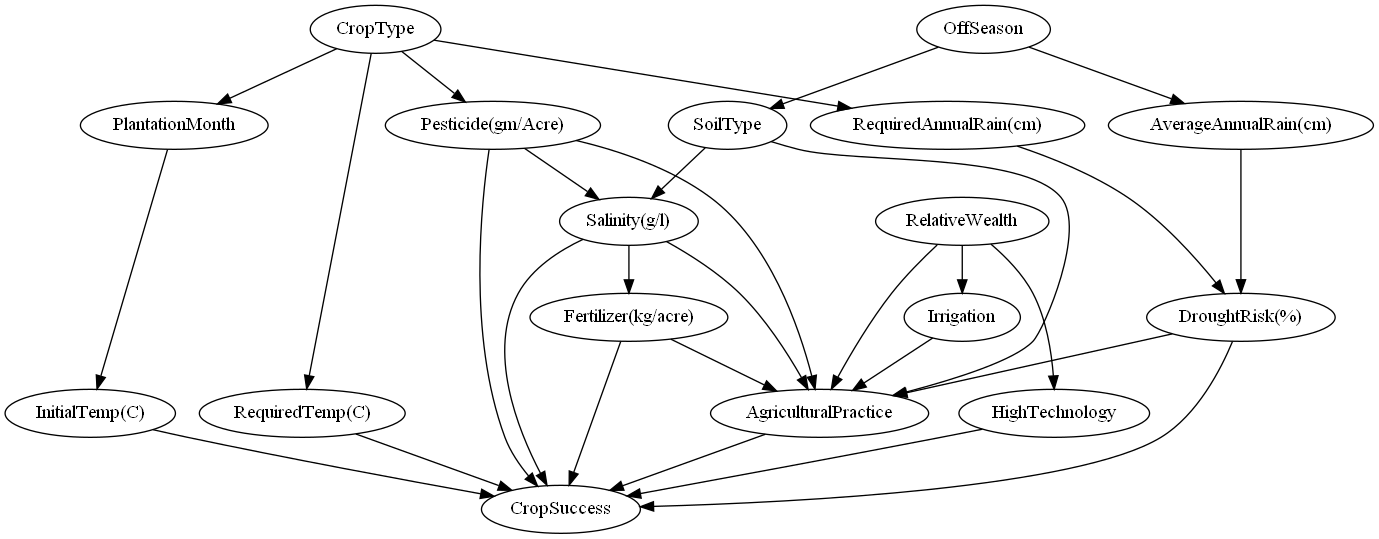

digraph {
	Location [label=OffSeason]
	CropType [label=CropType]
	"AverageAnnualRain(cm)" [label="AverageAnnualRain(cm)"]
	"RequiredAnnualRain(cm)" [label="RequiredAnnualRain(cm)"]
	PlantationMonth [label=PlantationMonth]
	"InitialTemp(C)" [label="InitialTemp(C)"]
	"RequiredTemp(C)" [label="RequiredTemp(C)"]
	SoilType [label=SoilType]
	"Pesticide(gm/Acre)" [label="Pesticide(gm/Acre)"]
	"Salinity(g/l)" [label="Salinity(g/l)"]
	"Fertilizer(kg/acre)" [label="Fertilizer(kg/acre)"]
	"DroughtRisk(%)" [label="DroughtRisk(%)"]
	HighTechnology [label=HighTechnology]
	RelativeWealth [label=RelativeWealth]
	AgriculturalPractice [label=AgriculturalPractice]
	CropSuccess [label=CropSuccess]
	Location -> "AverageAnnualRain(cm)"
	Location -> SoilType
	CropType -> "RequiredAnnualRain(cm)"
	CropType -> PlantationMonth
	CropType -> "RequiredTemp(C)"
	CropType -> "Pesticide(gm/Acre)"
	"AverageAnnualRain(cm)" -> "DroughtRisk(%)"
	"RequiredAnnualRain(cm)" -> "DroughtRisk(%)"
	Irrigation -> AgriculturalPrac

In [24]:
import graphviz


from IPython.display import Image, display

dot = graphviz.Digraph() 

dot.node('Location', 'OffSeason')  
dot.node('CropType', 'CropType')
dot.node('AverageAnnualRain(cm)', 'AverageAnnualRain(cm)')
dot.node('RequiredAnnualRain(cm)', 'RequiredAnnualRain(cm)')
dot.node('PlantationMonth','PlantationMonth')
 
dot.node('InitialTemp(C)','InitialTemp(C)')
dot.node('RequiredTemp(C)', 'RequiredTemp(C)')
dot.node('SoilType','SoilType')
dot.node('Pesticide(gm/Acre)','Pesticide(gm/Acre)')
dot.node('Salinity(g/l)','Salinity(g/l)')
dot.node('Fertilizer(kg/acre)','Fertilizer(kg/acre)')
dot.node('DroughtRisk(%)','DroughtRisk(%)')
dot.node('HighTechnology','HighTechnology')
dot.node('RelativeWealth','RelativeWealth')
dot.node('AgriculturalPractice','AgriculturalPractice')
dot.node('CropSuccess','CropSuccess')


dot.edge('Location','AverageAnnualRain(cm)')
dot.edge('Location','SoilType')
dot.edge('CropType','RequiredAnnualRain(cm)')
dot.edge('CropType','PlantationMonth')
dot.edge('CropType','RequiredTemp(C)')
dot.edge('CropType','Pesticide(gm/Acre)')
dot.edge('AverageAnnualRain(cm)','DroughtRisk(%)')
dot.edge('RequiredAnnualRain(cm)','DroughtRisk(%)')
dot.edge('Irrigation','AgriculturalPractice')
dot.edge('PlantationMonth','InitialTemp(C)')
dot.edge('InitialTemp(C)','CropSuccess')
dot.edge('RequiredTemp(C)','CropSuccess')
dot.edge('SoilType','Salinity(g/l)')
dot.edge('SoilType','AgriculturalPractice')
dot.edge('Pesticide(gm/Acre)','Salinity(g/l)')
dot.edge('Pesticide(gm/Acre)','AgriculturalPractice')
dot.edge('Pesticide(gm/Acre)','CropSuccess')
dot.edge('Salinity(g/l)','Fertilizer(kg/acre)')
dot.edge('Salinity(g/l)','AgriculturalPractice')
dot.edge('Salinity(g/l)','CropSuccess')
dot.edge('Fertilizer(kg/acre)','AgriculturalPractice')
dot.edge('Fertilizer(kg/acre)','CropSuccess')
dot.edge('DroughtRisk(%)','AgriculturalPractice')
dot.edge('DroughtRisk(%)','CropSuccess')
dot.edge('HighTechnology','CropSuccess')
dot.edge('RelativeWealth','HighTechnology')
dot.edge('RelativeWealth','AgriculturalPractice')
dot.edge('RelativeWealth','Irrigation')
dot.edge('AgriculturalPractice','CropSuccess')



dot.format = 'png'
dot.render(directory='doctest-output', view = True).replace('\\', '/')
display(Image(filename="doctest-output/Digraph.gv.png"))



print(dot.source)



What we aim to do here is to block out all confounding paths in this graph.
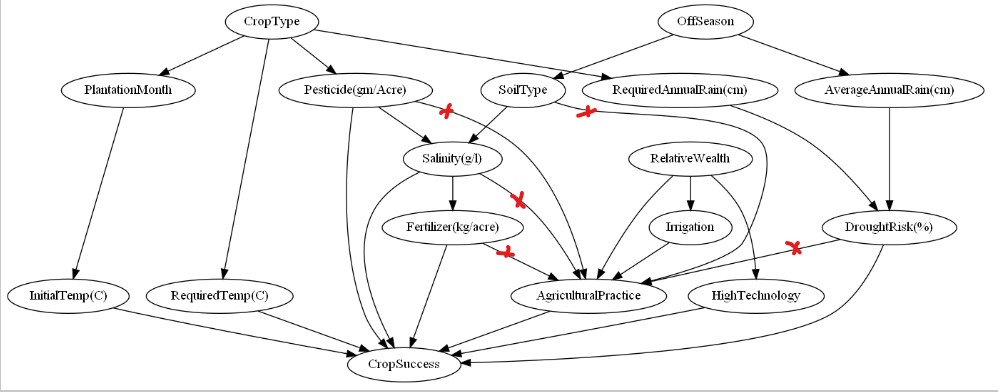

By blocking these paths by conditioning over those respective nodes, we can get comparative groups for T=1 and T=0 and thus we can estimate the Average Treatment Effect.

# Viewing the Model

Below, we create a causal model with all the given paramatres and see the causal graph.

0      0.0
1      1.0
2      0.0
3      1.0
4      1.0
      ... 
995    0.0
996    0.0
997    0.0
998    0.0
999    1.0
Name: CropSuccess, Length: 1000, dtype: float64


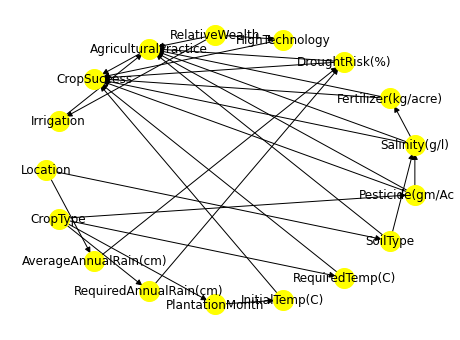

In [25]:
import dowhy


model = dowhy.CausalModel(data=agri,
                     graph=dot.source.replace("\n", " "),
                     treatment="AgriculturalPractice",
                     outcome="CropSuccess")
model.view_model()

print(agri['CropSuccess'])

Using the model's identify_effect method we can figure out the causal estimand that needs to be estimated.

source: https://youtu.be/dB8r4Afmobo

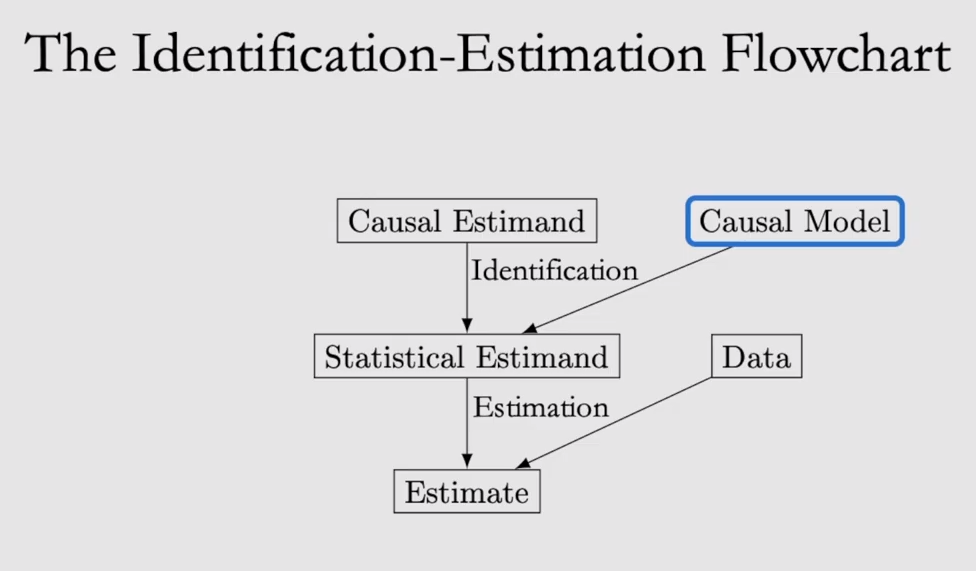

The model that we are creating is going to help us to turn this causal quantity into a statistical quanity that can be estimated by conditioning over all the confounders.

# Identifying the Estimand

In [26]:

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
───────────────────────(E[CropSuccess|Pesticide(gm/Acre),AverageAnnualRain(cm)
d[AgriculturalPractice]                                                       

                                                                  
,RelativeWealth,Fertilizer(kg/acre),DroughtRisk(%),Salinity(g/l)])
                                                                  
Estimand assumption 1, Unconfoundedness: If U→{AgriculturalPractice} and U→CropSuccess then P(CropSuccess|AgriculturalPractice,Pesticide(gm/Acre),AverageAnnualRain(cm),RelativeWealth,Fertilizer(kg/acre),DroughtRisk(%),Salinity(g/l),U) = P(CropSuccess|AgriculturalPractice,Pesticide(gm/Acre),AverageAnnualRain(cm),RelativeWealth,Fertilizer(kg/acre),DroughtRisk(%),Salinity(g/l))

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estima

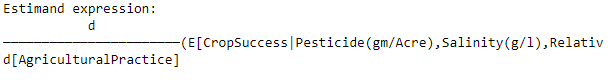

You can see that the estimand generated here is a statistical one that we can estimate using DoWhy's estimate_effect method.

In effect we turned E[Y|do(T=1)- Y|do(T=0)] the causal quantity we wanted into E[Y|T=1,W=w] - E[Y|T=0,W=w] marginalized over all W's to block the confounding paths here. 

# Evaluating the Statistical Estimand

In [27]:

estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.propensity_score_matching",
                                target_units="att")
print(estimate)

propensity_score_matching
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
───────────────────────(E[CropSuccess|Pesticide(gm/Acre),AverageAnnualRain(cm)
d[AgriculturalPractice]                                                       

                                                                  
,RelativeWealth,Fertilizer(kg/acre),DroughtRisk(%),Salinity(g/l)])
                                                                  
Estimand assumption 1, Unconfoundedness: If U→{AgriculturalPractice} and U→CropSuccess then P(CropSuccess|AgriculturalPractice,Pesticide(gm/Acre),AverageAnnualRain(cm),RelativeWealth,Fertilizer(kg/acre),DroughtRisk(%),Salinity(g/l),U) = P(CropSuccess|AgriculturalPractice,Pesticide(gm/Acre),AverageAnnualRain(cm),RelativeWealth,Fertilizer(kg/acre),DroughtRisk(%),Salinity(g/l))

## Realized 

# Meaning of the Estimate

This estimate gives us the true value of the difference in agricultural practices' effect on crop outcome.

A mean value of 0.665 for  E[Y|do(T=1)- Y|do(T=0)] tells us that difference in success rates for crop rotation plants and non crop rotation plants is around 0.66 where 1 means total success and 0 means total failure.

# Counterfactuals

An important part of causal inference is finding out counterfactuals.

For example: Observed data can be a situation wherein a person having a headache, takes a pill and the headache fades i.e Y(1).
A problem comes up i.e what if the person hadn;t taken the pill i.e Y(0). What would the outcome Y(0) be? We can't go back in time and then observe what could have been in observation based experiments. 

Thus DoWhy's gcm helps us generate accurate counterfactuals for certain rows of data.

In [23]:
import networkx as nx, numpy as np, pandas as pd
from dowhy import gcm
import matplotlib.pyplot as plt

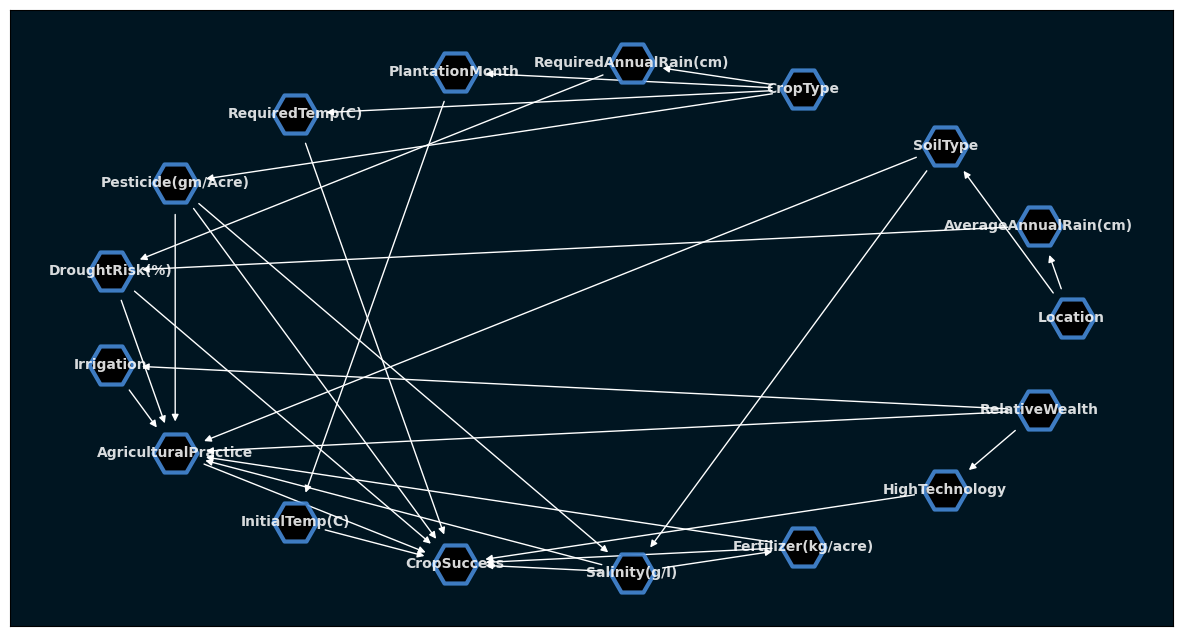

In [24]:
causal_graph = nx.DiGraph([('Location','AverageAnnualRain(cm)'),
('Location','SoilType'),
('CropType','RequiredAnnualRain(cm)'),
('CropType','PlantationMonth'),
('CropType','RequiredTemp(C)'),
('CropType','Pesticide(gm/Acre)'),
('AverageAnnualRain(cm)','DroughtRisk(%)'),
('RequiredAnnualRain(cm)','DroughtRisk(%)'),
('Irrigation','AgriculturalPractice'),
('PlantationMonth','InitialTemp(C)'),
('InitialTemp(C)','CropSuccess'),
('RequiredTemp(C)','CropSuccess'),
('SoilType','Salinity(g/l)'),
('SoilType','AgriculturalPractice'),
('Pesticide(gm/Acre)','Salinity(g/l)'),
('Pesticide(gm/Acre)','AgriculturalPractice'),
('Pesticide(gm/Acre)','CropSuccess'),
('Salinity(g/l)','Fertilizer(kg/acre)'),
('Salinity(g/l)','AgriculturalPractice'),
('Salinity(g/l)','CropSuccess'),
('Fertilizer(kg/acre)','AgriculturalPractice'),
('Fertilizer(kg/acre)','CropSuccess'),
('DroughtRisk(%)','AgriculturalPractice'),
('DroughtRisk(%)','CropSuccess'),
('HighTechnology','CropSuccess'),
('RelativeWealth','HighTechnology'),
('RelativeWealth','AgriculturalPractice'),
('RelativeWealth','Irrigation'),
('AgriculturalPractice','CropSuccess')])

fig = plt.figure(figsize=(15, 8))  # set figsize
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor("#001521")  # set backgrount

pos = nx.drawing.layout.circular_layout(causal_graph)

nx.draw_networkx_nodes(
    causal_graph,
    pos,
    node_shape="H",
    node_size=1000,
    linewidths=3,
    edgecolors="#4a90e2d9",
    node_color=["black"],
)
# add labels
nx.draw_networkx_labels(
    causal_graph,
    pos,
    font_color="#FFFFFFD9",
    font_weight="bold",
    
    font_size=10,
)
# add edges
nx.draw_networkx_edges(
    causal_graph,
    pos,
    edge_color="white",
    node_shape="H",
    node_size=2000,
    
    width=[1],
)

In [25]:
causal_model = gcm.InvertibleStructuralCausalModel(causal_graph) 
gcm.auto.assign_causal_mechanisms(causal_model, agri)
gcm.fit(causal_model, agri)

Fitting causal mechanism of node RelativeWealth: 100%|█████████████████████████████████| 17/17 [00:03<00:00,  5.33it/s]


In [26]:
pred=gcm.counterfactual_samples(
    causal_model,
    { 'RelativeWealth' : lambda x : x,'AgriculturalPractice' : lambda x :1, 'SoilType' : lambda x :x,
     'Irrigation' : lambda x :x, 'HighTechnology':lambda x : x,'CropType' : lambda x :x, 
     'Pesticide(gm/Acre)' : lambda x :x, 'RequiredTemp(C)' : lambda x:x,'PlantationMonth' : lambda x:x,
     'InitialTemp(C)' : lambda x:x,'RequiredAnnualRain(cm)' : lambda x:x,'Location' : lambda x :x,
     'SoilType' : lambda x:x,'Salinity(g/l)' : lambda x:x,'Fertilizer(kg/acre)' :lambda x:x,
     'AverageAnnualRain(cm)' :lambda x:x,'DroughtRisk(%)' : lambda x:x,'AgriculturalPractice' :lambda x:1
     
     
    },
    observed_data=agri)
print(pred)
print(agri)

print(agri['CropSuccess'].mean()- pred['CropSuccess'].mean(), " is the average difference between them unadjusted")

              Location   CropType  RelativeWealth  AverageAnnualRain(cm)  \
0                 Supe     cotton               0                   60.0   
1          Malegaon Bk      wheat               1                   82.0   
2          Malegaon Bk     cotton               1                   57.0   
3          Malegaon Bk  sugarcane               0                  141.0   
4         Loni Bhapkar      wheat               0                   76.0   
..                 ...        ...             ...                    ...   
995     Baramati Rural     grapes               0                   75.0   
996     Baramati Rural      wheat               0                   78.0   
997               Supe     cotton               0                   51.0   
998  Vadgaon Nimbalkar  sugarcane               0                  134.0   
999        Malegaon Bk     grapes               0                   83.0   

     SoilType  RequiredAnnualRain(cm)  PlantationMonth  RequiredTemp(C)  \
0         1.

# Refuting the Estimate

An important part of causal inference is to show whether the increase in success rates we observed was not a random occurance. In order to do so, we use a placebo treatment instead of the real one and observe the conditional average treatment effect then to see if that change is less significant than the one we calculated.

In [136]:

refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                     placebo_type="permute", num_simulations=20)
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:0.6654611211573237
New effect:0.019891500904159136
p value:0.29718488236467144



We can see that the our original effect was 0.66 whereas the new effect due to the placebo treatment is a measly 0.02.
The difference in their magnitudes show us that our treatment effect was solely due to the treatment and not due to randomisation.